In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras import callbacks
from dateutil.parser import parse
import textblob
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import re
from sklearn.model_selection import train_test_split


In [2]:
# Set up NLTK
#nltk.download('punkt')
#nltk.download('stopwords')

In [3]:
# Suppress matplotlib warnings
#from matplotlib.axes._axes import _log as matplotlib_axes_logger
#matplotlib_axes_logger.setLevel('ERROR')

In [4]:
# Load datasets
def load_dataset(path):
    return pd.read_csv(path, names=['review', 'sentiments'], sep='\t')

amazon_df = load_dataset('amazon_cells_labelled.txt')
imdb_df = load_dataset('imdb_labelled.txt')
yelp_df = load_dataset('yelp_labelled.txt')

In [5]:
# Display datasets
def display_dataset(name, df):
    print(f"{name}: {df.head(15)}")

display_dataset('Amazon', amazon_df)
display_dataset('IMDB', imdb_df)
display_dataset('Yelp', yelp_df)

Amazon:                                                review  sentiments
0   So there is no way for me to plug it in here i...           0
1                         Good case, Excellent value.           1
2                              Great for the jawbone.           1
3   Tied to charger for conversations lasting more...           0
4                                   The mic is great.           1
5   I have to jiggle the plug to get it to line up...           0
6   If you have several dozen or several hundred c...           0
7         If you are Razr owner...you must have this!           1
8                 Needless to say, I wasted my money.           0
9                    What a waste of money and time!.           0
10                    And the sound quality is great.           1
11  He was very impressed when going from the orig...           1
12  If the two were seperated by a mere 5+ ft I st...           0
13                           Very good quality though           1
14

In [6]:
# Review dataset sizes
def review_dataset_size(df, name):
    print(f"{name}: {df.shape}")

review_dataset_size(amazon_df, 'Amazon')
review_dataset_size(imdb_df, 'IMDB')
review_dataset_size(yelp_df, 'Yelp')

Amazon: (1000, 2)
IMDB: (748, 2)
Yelp: (1000, 2)


In [7]:
# Review individual DataFrame info and shapes
print("Amazon:")
amazon_df.info()
print("IMDB:", imdb_df.shape)
imdb_df.info()
print("Yelp:", yelp_df.shape)
yelp_df.info()

Amazon:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      1000 non-null   object
 1   sentiments  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
IMDB: (748, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      748 non-null    object
 1   sentiments  748 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB
Yelp: (1000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      1000 non-null   object
 1   sentiments  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [8]:
# Combine the three labeled review files
dataframes = [amazon_df, imdb_df, yelp_df]
combined_df = reduce(lambda left, right: pd.merge(left, right, on=['review', 'sentiments'], how='outer'), dataframes)


In [9]:
# Check combined DataFrame
combined_df.info()

# Check for null values
null_counts = combined_df.isnull().sum()
print(null_counts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      2748 non-null   object
 1   sentiments  2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB
review        0
sentiments    0
dtype: int64


In [10]:
# Check missing data and its size
def missing_cols(df):
    """Prints columns with their amount of missing values."""
    total = df.isnull().sum().sum()
    if total == 0:
        print("There are no missing values.")
    else:
        for col, missing_vals in df.isnull().sum().items():
            if missing_vals != 0:
                print(f"{col} => {missing_vals}")

missing_cols(combined_df)

# Check combined DataFrame info
print("Combined DataFrame Info:")
combined_df.info()

There are no missing values.
Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      2748 non-null   object
 1   sentiments  2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB


In [11]:
# Check combined DataFrame columns
print("Combined DataFrame Columns:")
print(combined_df.columns)

# Check combined DataFrame type
print("Combined DataFrame Type:")
print(type(combined_df))

# Check data types of features
print("Data Types of Features:")
print(combined_df.dtypes)

# Check binary rating (0 = negative, 1 = positive)
print("Binary Rating (0 = Negative, 1 = Positive):")
print(combined_df['sentiments'].unique())

Combined DataFrame Columns:
Index(['review', 'sentiments'], dtype='object')
Combined DataFrame Type:
<class 'pandas.core.frame.DataFrame'>
Data Types of Features:
review        object
sentiments     int64
dtype: object
Binary Rating (0 = Negative, 1 = Positive):
[0 1]


Sentiments Count:
sentiments
1    1386
0    1362
Name: count, dtype: int64
Sentiments Distribution (Count):
sentiments
1    0.504367
0    0.495633
Name: count, dtype: float64
Dataset Statistics:
        sentiments
count  2748.000000
mean      0.504367
std       0.500072
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000


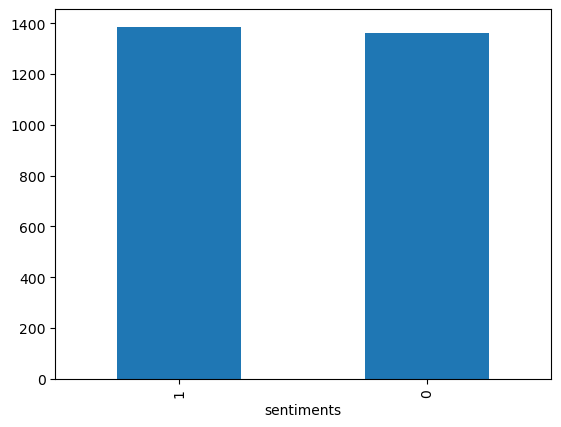

In [12]:
# Check positive and negative reviews from combined DataFrame
print("Sentiments Count:")
print(combined_df.sentiments.value_counts())

# Analyze distribution of the ratings (sentiments)
print("Sentiments Distribution (Count):")
print(combined_df.sentiments.value_counts() / len(combined_df))

# Plot sentiments distribution
combined_df['sentiments'].value_counts().plot(kind='bar')

# Describe dataset statistics
print("Dataset Statistics:")
print(combined_df.describe())

In [13]:
# Check for emoji ":D"
print("Lines containing :D emoji:")
for review in combined_df.review:
    if ":D" in review:
        print("The line contains :D emoji")

Lines containing :D emoji:


In [14]:
# Check for unusual characters
def is_english(review):
    return review.isascii()

print("Non-English reviews:")
for review in combined_df.review:
    if not is_english(review):
        print(review)

Non-English reviews:
It's practically perfect in all of them  a true masterpiece in a sea of faux "masterpieces.  
 The structure of this film is easily the most tightly constructed in the history of cinema.  	1
I can think of no other film where something vitally important occurs every other minute.  	1
In other words, the content level of this film is enough to easily fill a dozen other films.  	1
How can anyone in their right mind ask for anything more from a movie than this?  	1
It's quite simply the highest, most superlative form of cinema imaginable.  	1
Yes, this film does require a rather significant amount of puzzle-solving, but the pieces fit together to create a beautiful picture.  	1
This short film certainly pulls no punches.  	0
Graphics is far from the best part of the game.  	0
This is the number one best TH game in the series.  	1
It deserves strong love.  	1
It is an insane game.  	1
There are massive levels, massive unlockable characters... it's just a massive game.

In [15]:
# Check vocabulary size and proposed word embedding length
reviews_length = combined_df['review'].str.len()

# Estimate vocabulary size (number of unique words)
unique_words = set(combined_df['review'].str.replace('[^a-zA-Z]', '').str.lower().str.split().sum())
print(f"There are {len(unique_words)} unique words in the reviews.")

# Check length of shortest review
print(f"The shortest review is {min(reviews_length)} words.")

# Check length of longest review
print(f"The longest review is {max(reviews_length)} words.")

# Check total length of all reviews
print(f"The total length of all reviews is {sum(reviews_length)} characters.")


There are 7349 unique words in the reviews.
The shortest review is 7 words.
The longest review is 7944 words.
The total length of all reviews is 196560 characters.


In [16]:
#import nltk
#from nltk import word_tokenize
#from nltk.corpus import stopwords
#import re
#import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
# Tokenize words
word_tokens = [word_tokenize(review) for review in combined_df.review]
print('Word Tokenization first 10 reviews:\n', word_tokens[:10])

# Count words in the reviews column
combined_df['word_count'] = combined_df['review'].str.split().str.len()
print('Average words per review:', combined_df['word_count'].mean())

# Clean reviews: lowercase, remove numbers and special characters, remove stopwords
combined_df['clean_review'] = combined_df['review'].str.lower()
combined_df['clean_review'] = combined_df['clean_review'].str.replace('\d+', '')
unique_characters = ["*", "+", ",", "-", ".", "/", ":", ";", "<", "=", ">", "?", "@", "!", '"', "#", "%", "&", "'", "(", ")", "[", "\\", "]", "^", "_", "`", "{", "|", "}", "~", "–"]
for char in unique_characters:
    combined_df['clean_review'] = combined_df['clean_review'].str.replace(re.escape(char), ' ', regex=True)
stop_words = stopwords.words('english')
combined_df['clean_review'] = combined_df['clean_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

# Remove specific words
remove_words = ['film', 'get', 'good', 'like', 'movie', 'phone', 'work']
combined_df['clean_review'] = combined_df['clean_review'].apply(lambda x: " ".join(x for x in x.split() if x not in remove_words))

Word Tokenization first 10 reviews:
 [['So', 'there', 'is', 'no', 'way', 'for', 'me', 'to', 'plug', 'it', 'in', 'here', 'in', 'the', 'US', 'unless', 'I', 'go', 'by', 'a', 'converter', '.'], ['Good', 'case', ',', 'Excellent', 'value', '.'], ['Great', 'for', 'the', 'jawbone', '.'], ['Tied', 'to', 'charger', 'for', 'conversations', 'lasting', 'more', 'than', '45', 'minutes.MAJOR', 'PROBLEMS', '!', '!'], ['The', 'mic', 'is', 'great', '.'], ['I', 'have', 'to', 'jiggle', 'the', 'plug', 'to', 'get', 'it', 'to', 'line', 'up', 'right', 'to', 'get', 'decent', 'volume', '.'], ['If', 'you', 'have', 'several', 'dozen', 'or', 'several', 'hundred', 'contacts', ',', 'then', 'imagine', 'the', 'fun', 'of', 'sending', 'each', 'of', 'them', 'one', 'by', 'one', '.'], ['If', 'you', 'are', 'Razr', 'owner', '...', 'you', 'must', 'have', 'this', '!'], ['Needless', 'to', 'say', ',', 'I', 'wasted', 'my', 'money', '.'], ['What', 'a', 'waste', 'of', 'money', 'and', 'time', '!', '.']]
Average words per review: 13.0

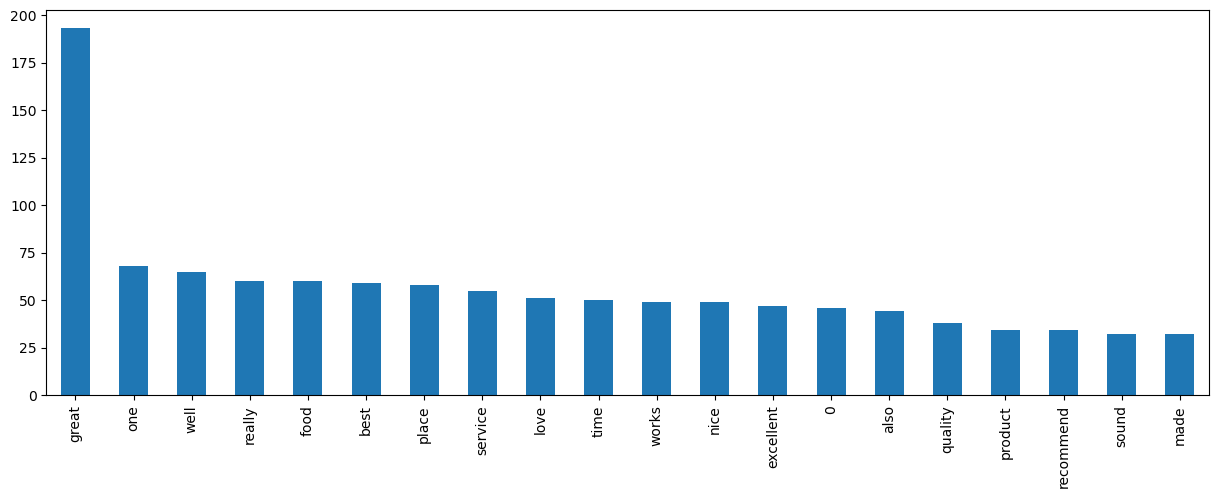

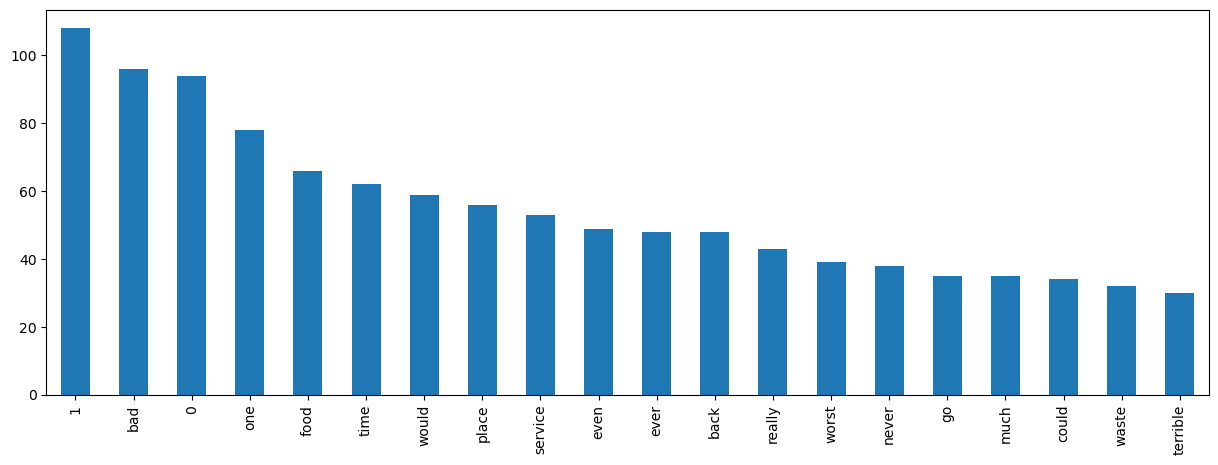

In [18]:


# Separate positive and negative reviews
positive_reviews = combined_df[combined_df['sentiments'] == 1]['clean_review']
negative_reviews = combined_df[combined_df['sentiments'] == 0]['clean_review']

# Visualization
split_df = [positive_reviews, negative_reviews]
for item in split_df:
    plt.figure(figsize=(15, 5))
    pd.Series(' '.join([i for i in item]).split()).value_counts().head(20).plot(kind='bar')
    plt.show()


In [19]:
# Split the dataset
X = combined_df['clean_review']
y = combined_df['sentiments']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print('Shape of training set:', X_train.shape[0])
print('Shape of test set:', X_test.shape[0])

# Set up tokenization and padding
vocab_size = 2200
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = ''

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Shape of training set: 2198
Shape of test set: 550
Vocabulary size: 4447


In [20]:
# Split the data set
split = round(len(combined_df) * 0.8)
train_reviews = combined_df['clean_review'][:split]
train_labels = combined_df['sentiments'][:split]
test_reviews = combined_df['clean_review'][split:]
test_labels = combined_df['sentiments'][split:]
print('Shape of training set:', train_reviews.shape[0])
print('Shape of test set:', test_reviews.shape[0])

# Set up tokenization and padding
vocab_size = 2200
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_reviews)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Shape of training set: 2198
Shape of test set: 550
Vocabulary size: 4566


In [21]:
# Prepare padded sequences for training and testing
train_sequences = tokenizer.texts_to_sequences(train_reviews)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
train_labels_final = np.array(train_labels)

test_sequences = tokenizer.texts_to_sequences(test_reviews)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_labels_final = np.array(test_labels)

In [30]:
print("Training sequences:\n", train_reviews)

Training sequences:
 0                         way plug us unless go converter
1                                    case excellent value
2                                           great jawbone
3       tied charger conversations lasting 45 minutes ...
4                                               mic great
                              ...                        
2193       anyway fs restaurant wonderful breakfast lunch
2194                                      nothing special
2195                    day week different deal delicious
2196    mention combination pears almonds bacon big wi...
2197                                                 back
Name: clean_review, Length: 2198, dtype: object


In [22]:
# Ensure consistency in the splitting logic
print(len(train_reviews), len(train_labels))
print(len(test_reviews), len(test_labels))

2198 2198
550 550


In [23]:
# Display counts of sentiments
sentiments_count = combined_df.groupby('sentiments').count()
print(sentiments_count)

# Save prepared dataset to CSV
combined_df.to_csv("combined_df_prepared_nlp.csv", index=False)

            review  word_count  clean_review
sentiments                                  
0             1362        1362          1362
1             1386        1386          1386


In [24]:
# Prepare labels for training
train_labels_final = np.array(train_labels)
test_labels_final = np.array(test_labels)


# Create and compile TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           35200     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 6)                 66        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 35443 (138.45 KB)
Trainable params: 35443 (138.45 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [25]:
# Fit model for 15 epochs
epochs_num = 15
history_model1 = model.fit(padded_train_sequences, train_labels_final, epochs=epochs_num, validation_data=(padded_test_sequences, test_labels_final))

Epoch 1/15


69/69 [==============================] - 3s 11ms/step - loss: 0.6929 - accuracy: 0.5241 - val_loss: 0.6961 - val_accuracy: 0.4545
Epoch 2/15
69/69 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5168 - val_loss: 0.6968 - val_accuracy: 0.4545
Epoch 3/15
69/69 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5168 - val_loss: 0.6956 - val_accuracy: 0.4545
Epoch 4/15
69/69 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5173 - val_loss: 0.6977 - val_accuracy: 0.4545
Epoch 5/15
69/69 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5168 - val_loss: 0.6958 - val_accuracy: 0.4545
Epoch 6/15
69/69 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.5173 - val_loss: 0.6920 - val_accuracy: 0.4545
Epoch 7/15
69/69 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.6051 - val_loss: 0.6848 - val_accuracy: 0.4618
Epoch 8/15
69/69 

In [26]:
# Fit model for 15 epochs with early stopping
history_model2 = model.fit(padded_train_sequences, train_labels_final, epochs=epochs_num, validation_data=(padded_test_sequences, test_labels_final), callbacks=[EarlyStopping(monitor='val_loss')])

Epoch 1/15
69/69 [==============================] - 0s 4ms/step - loss: 0.2569 - accuracy: 0.9199 - val_loss: 0.5003 - val_accuracy: 0.7382
Epoch 2/15
69/69 [==============================] - 0s 4ms/step - loss: 0.2326 - accuracy: 0.9222 - val_loss: 0.5150 - val_accuracy: 0.7327


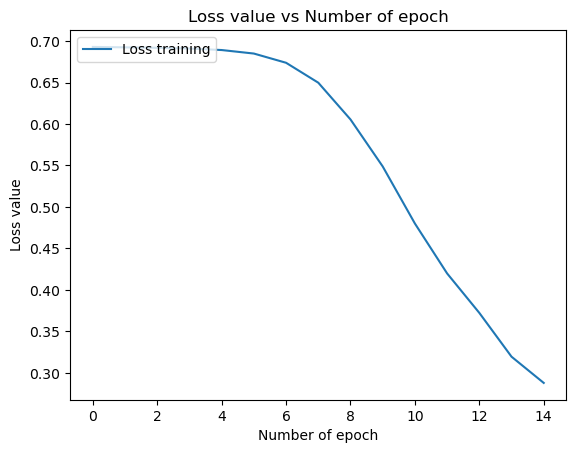

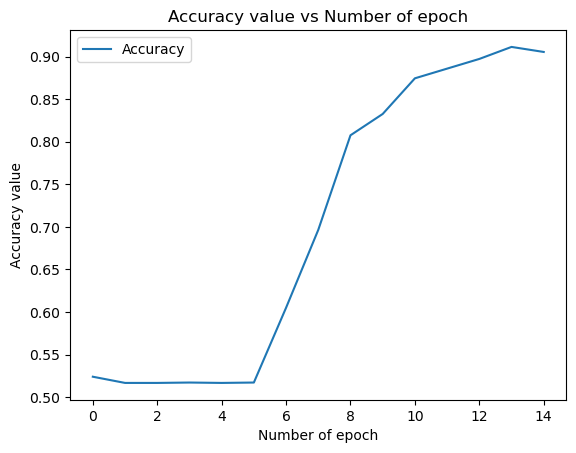

In [27]:
# Plot loss vs. epoch
plt.plot(history_model1.history['loss'], label='Loss training')
plt.title('Loss value vs Number of epoch')
plt.xlabel('Number of epoch')
plt.ylabel('Loss value')
plt.legend(loc="upper left")
plt.show()

# Plot accuracy vs. epoch
plt.plot(history_model1.history['accuracy'], label='Accuracy')
plt.title('Accuracy value vs Number of epoch')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy value')
plt.legend(loc="upper left")
plt.show()

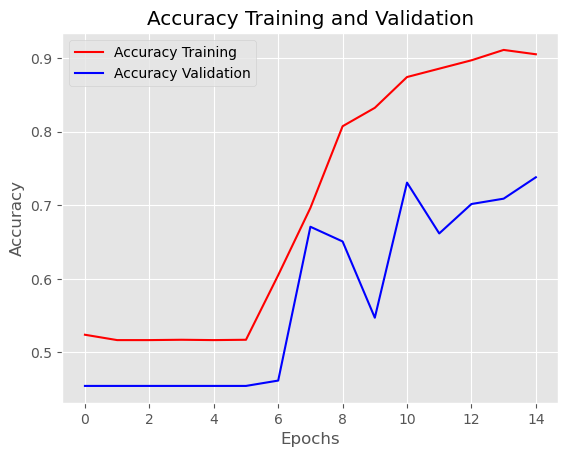

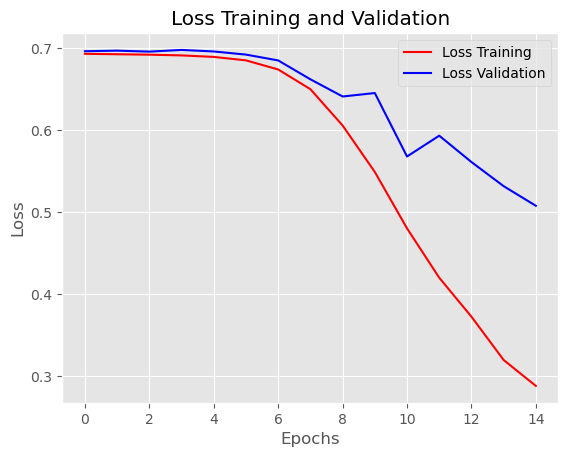

In [28]:

# Visualize model alongside loss function
plt.style.use('ggplot')

history = history_model1.history

plt.plot(history['accuracy'], 'r', label='Accuracy Training')
plt.plot(history['val_accuracy'], 'b', label='Accuracy Validation')
plt.title('Accuracy Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history['loss'], 'r', label='Loss Training')
plt.plot(history['val_loss'], 'b', label='Loss Validation')
plt.title('Loss Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [29]:
# Analyze the model
accuracy = model.evaluate(padded_train_sequences, train_labels_final, verbose=0)[1] * 100
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 93.54%
